<a href="https://colab.research.google.com/github/saarangp/dreammachines/blob/main/Sparse_Coding_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Coding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import tensorflow as tf

from scipy.io import loadmat
from tqdm import tqdm
import os

if "dreammachines" not in os.listdir():
    !git clone https://github.com/saarangp/dreammachines
from dreammachines.sparse_coding import SparseCodingModel
from dreammachines.sparse_coding_utils import get_bar_images, get_mnist_images, get_natural_images, create_patchwork, resize_images, image_MSE, image_PSNR
from dreammachines.helmholtz import helmholtz, SparseHelmholtz

Cloning into 'dreammachines'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 262 (delta 146), reused 173 (delta 72), pack-reused 0
Receiving objects: 100% (262/262), 18.07 MiB | 19.24 MiB/s, done.
Resolving deltas: 100% (146/146), done.


## Bar Images

In [ ]:
model = SparseCodingModel(256, 64, 0.001)
X_train = get_bar_images(4000, 16, 16)
model.train(X_train, num_steps=3000)

100% (100 of 100) |######################| Elapsed Time: 0:00:47 Time:  0:00:47


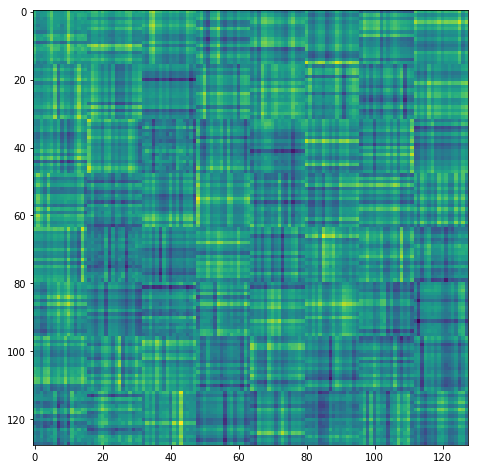

In [ ]:
bar_features = create_patchwork(model.Phi, 8, 8, (16, 16))
plt.figure(figsize=(8, 8))
plt.imshow(bar_features)
plt.show()

In [ ]:
X_test = get_bar_images(10, 16, 16)
activations = model.predict(X_test, num_steps=3000)
X_pred = model.generate(activations)

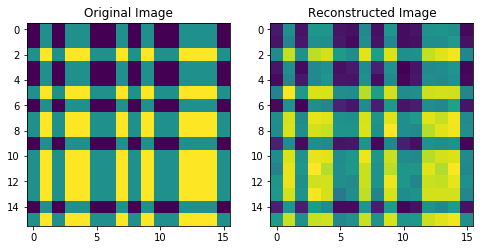

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(X_test[2].reshape(16, 16))
ax1.set_title("Original Image")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(X_pred[:, 2].reshape(16, 16))
ax2.set_title("Reconstructed Image")

plt.show()

## With Numbers

In [ ]:
num_dataset = get_mnist_images(number=-1)
num_model = SparseCodingModel(200, 64, 0.005)
num_model.train(num_dataset, num_steps=100)

100% (10 of 10) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


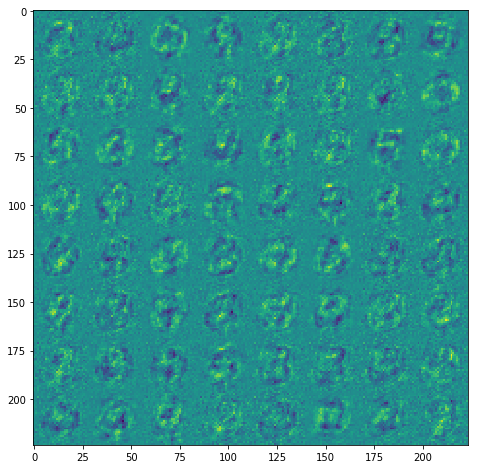

In [ ]:
bar_features = create_patchwork(num_model.Phi, 8, 8, (28, 28))
plt.figure(figsize=(8, 8))
plt.imshow(bar_features)
plt.show()

In [ ]:
X_test = num_dataset[:20]
activations = num_model.predict(X_test, num_steps=3000)
X_pred = num_model.generate(activations)

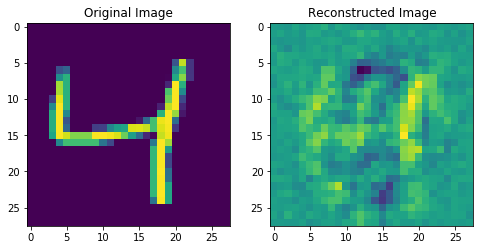

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(X_test[2].reshape(28, 28))
ax1.set_title("Original Image")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(X_pred[:, 2].reshape(28, 28))
ax2.set_title("Reconstructed Image")

plt.show()

## Natural images

In [108]:
if "IMAGES.mat" not in os.listdir():
    !wget https://github.com/hmallen99/vs265_files/raw/master/IMAGES.mat
img_mat = loadmat("IMAGES.mat")["IMAGES"]
X = get_natural_images(img_mat, 28)

In [109]:
nat_model = SparseCodingModel(100, 400, 0.01)
nat_model.train(X, num_steps=1)

100% (1 of 1) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05


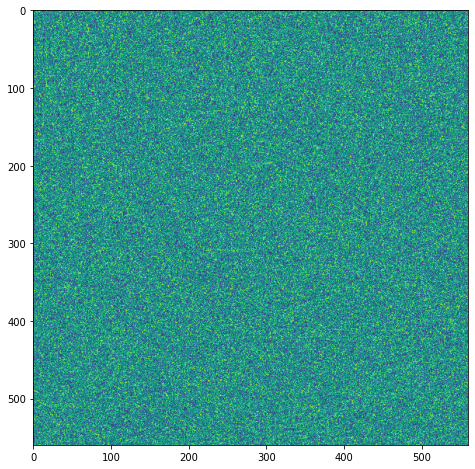

In [110]:
img = create_patchwork(nat_model.Phi, 20, 20, (28, 28))
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.savefig("natural_sparse_codes.png")

In [111]:
X_test = X[:20]
activations = nat_model.predict(X_test, num_steps=3000)
X_pred = nat_model.generate(activations)

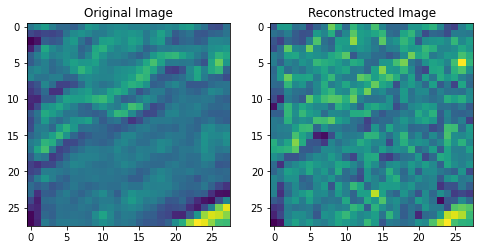

In [112]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(X_test[2].reshape(28, 28))
ax1.set_title("Original Image")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(X_pred[:, 2].reshape(28, 28))
ax2.set_title("Reconstructed Image")

plt.show()

# Dream Generation

In [146]:
#@markdown Load Model
num2_images = get_mnist_images(number=2)[:200]
nat_model = SparseCodingModel(50, 400, 0.01)
nat_model.load_Phi("dreammachines/model_weights/nat_features.npy")

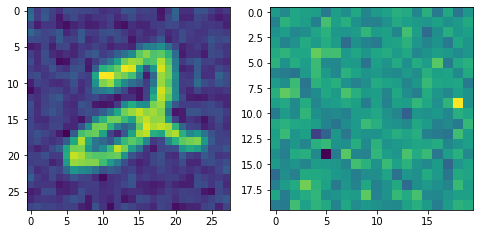

In [147]:
#@title MNIST Dream Generation
#@markdown Load Activations
num2_activations = nat_model.predict(num2_images)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(nat_model.generate(num2_activations[:, 0]).reshape(28, 28))

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(num2_activations[:, 0].reshape(20, 20))

plt.show()

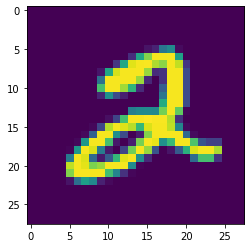

In [148]:
#@markdown Test Image
test_image = num2_images[0].reshape(28, 28) / 255
plt.imshow(test_image, vmin=0, vmax=1)
plt.show()

(784, 32)
(32, 1)


/content/dreammachines/helmholtz.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 50/50 [00:00<00:00, 757.57it/s]


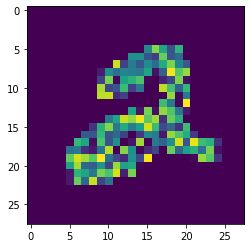

In [149]:
#@markdown Naive Helmholtz Model
naive_helmholtz = helmholtz([784, 32], 'beta', .05)
naive_helmholtz.train(num2_images[0].reshape(1, -1), n_iter=5000)

mses = []
psnrs = []
frames = [] 
fig = plt.figure()
for dream in tqdm(naive_helmholtz.dreams[::100]):
    dream = dream.reshape(28, 28)
    mses.append(image_MSE(test_image, dream))
    psnrs.append(image_PSNR(test_image, dream))
    frames.append([plt.imshow(dream, animated=True)])

naive_mean_MSE = np.array(mses).mean()
naive_min_MSE = np.array(mses).min()
naive_mean_PSNR = np.array(psnrs).mean()
naive_max_PSNR = np.array(psnrs).max()

plt.show()

(400, 32)
(32, 1)


/content/dreammachines/helmholtz.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 50/50 [00:00<00:00, 672.82it/s]


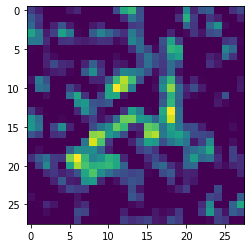

In [150]:
#@markdown Helmholtz + Sparse Coding Inputs
nat_helmholtz = helmholtz([400, 32], 'beta', .05)
nat_helmholtz.train(num2_activations[:, 0].reshape(1, -1), n_iter=5000)

mses = []
psnrs = []
frames = [] 
fig = plt.figure()
for dream in tqdm(nat_helmholtz.dreams[::100]):
    dream = nat_model.generate(dream).reshape(28, 28)
    mses.append(image_MSE(test_image, dream))
    psnrs.append(image_PSNR(test_image, dream))
    frames.append([plt.imshow(dream, vmin=0, vmax=1, animated=True)])

helm_mean_MSE = np.array(mses).mean()
helm_min_MSE = np.array(mses).min()
helm_mean_PSNR = np.array(psnrs).mean()
helm_max_PSNR = np.array(psnrs).max()
plt.show()

(400, 32)
(32, 1)


/content/dreammachines/helmholtz.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 50/50 [00:00<00:00, 672.69it/s]


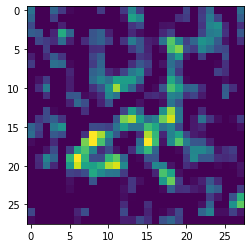

In [151]:
#@markdown Sparse Coding + Sparse Helmholtz
sparse_nat_helmholtz = SparseHelmholtz([400, 32], 'beta', .05)
sparse_nat_helmholtz.train(num2_activations[:, 0].reshape(1, -1), n_iter=5000)

mses = []
psnrs = []
frames = [] 
fig = plt.figure()
for dream in tqdm(sparse_nat_helmholtz.dreams[::100]):
    dream = nat_model.generate(dream).reshape(28, 28)
    mses.append(image_MSE(test_image, dream))
    psnrs.append(image_PSNR(test_image, dream))
    frames.append([plt.imshow(dream, vmin=0, vmax=1, animated=True)])

sparse_mean_MSE = np.array(mses).mean()
sparse_min_MSE = np.array(mses).min()
sparse_mean_PSNR = np.array(psnrs).mean()
sparse_max_PSNR = np.array(psnrs).max()
plt.show()

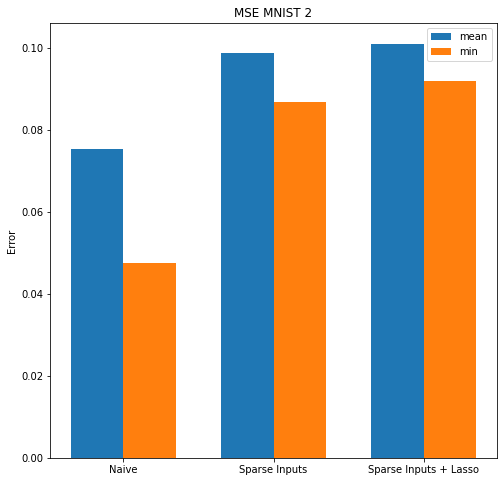

In [152]:
#@markdown Plot MSE for MNIST 2
mean_mses = [naive_mean_MSE, helm_mean_MSE, sparse_mean_MSE]
min_mses = [naive_min_MSE, helm_min_MSE, sparse_min_MSE]

x = np.arange(3)
width = 0.35

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.bar(x - width/2, mean_mses, width, label="mean")
ax.bar(x + width/2, min_mses, width, label="min")

ax.set_xticks(x)
ax.set_xticklabels(["Naive", "Sparse Inputs", "Sparse Inputs + Lasso"])

ax.set_title("MSE MNIST 2")
ax.set_ylabel("Error")
ax.legend()

plt.savefig("MSE_mnist.png")
plt.show()

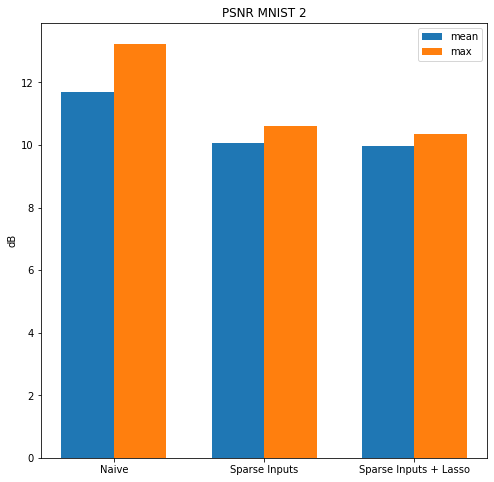

In [153]:
#@markdown Plot PSNR for Mnist 2

mean_psnrs = [naive_mean_PSNR, helm_mean_PSNR, sparse_mean_PSNR]
max_psnrs = [naive_max_PSNR, helm_max_PSNR, sparse_max_PSNR]

x = np.arange(3)
width = 0.35

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.bar(x - width/2, mean_psnrs, width, label="mean")
ax.bar(x + width/2, max_psnrs, width, label="max")

ax.set_xticks(x)
ax.set_xticklabels(["Naive", "Sparse Inputs", "Sparse Inputs + Lasso"])

ax.set_title("PSNR MNIST 2")
ax.set_ylabel("dB")
ax.legend()

plt.savefig("PNSR_mnist.png")
plt.show()

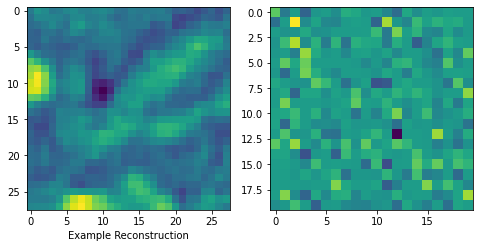

In [154]:
#@title Faces Dream Generation
#@markdown Load Activations

nat_activations = nat_model.predict(X[2000:2002])

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(nat_model.generate(nat_activations[:, 0]).reshape(28, 28))
ax1.set_xlabel("Example Reconstruction")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(nat_activations[:, 0].reshape(20, 20))

plt.show()

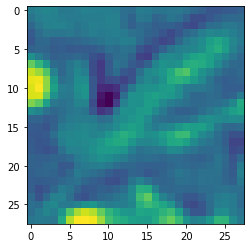

In [155]:
#@markdown Test Image
test_image = X[2000].reshape(28, 28) 
test_image = test_image - test_image.min()
test_image = test_image / test_image.max()

plt.imshow(test_image, vmin=0, vmax=1)
plt.show()

(784, 32)
(32, 1)


/content/dreammachines/helmholtz.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 50/50 [00:00<00:00, 696.68it/s]


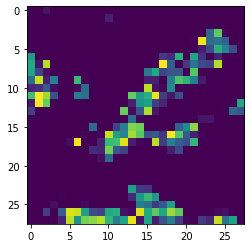

In [156]:
#@markdown Naive Model

naive_helmholtz = helmholtz([784, 32], 'beta', .05)
naive_helmholtz.train(X[2000].reshape(1, -1), n_iter=5000)

mses = []
psnrs = []
frames = [] 
fig = plt.figure()
for dream in tqdm(naive_helmholtz.dreams[::100]):
    dream = dream.reshape(28, 28)
    dream = dream - dream.min()
    dream = dream / dream.max()
    mses.append(image_MSE(test_image, dream))
    psnrs.append(image_PSNR(test_image, dream))
    frames.append([plt.imshow(dream, animated=True)])

naive_mean_MSE = np.array(mses).mean()
naive_min_MSE = np.array(mses).min()
naive_mean_PSNR = np.array(psnrs).mean()
naive_max_PSNR = np.array(psnrs).max()

plt.show()

(400, 32)
(32, 1)


/content/dreammachines/helmholtz.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 5/5 [00:00<00:00, 181.66it/s]


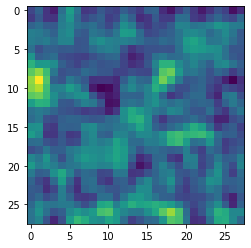

In [157]:
#@markdown Sparse Coding Inputs
nat_helmholtz = helmholtz([400, 32], 'beta', .05)
nat_helmholtz.train(nat_activations[:, 0].reshape(1, -1), n_iter=5000)

mses = []
psnrs = []
frames = [] 
fig = plt.figure()
for dream in tqdm(nat_helmholtz.dreams[::1000]):
    dream = nat_model.generate(dream).reshape(28, 28)
    dream = dream - dream.min()
    dream = dream / dream.max()
    mses.append(image_MSE(test_image, dream))
    psnrs.append(image_PSNR(test_image, dream))
    frames.append([plt.imshow(dream, vmin=0, vmax=1, animated=True)])

helm_mean_MSE = np.array(mses).mean()
helm_min_MSE = np.array(mses).min()
helm_mean_PSNR = np.array(psnrs).mean()
helm_max_PSNR = np.array(psnrs).max()
plt.show()

(400, 32)
(32, 1)


100%|██████████| 5/5 [00:00<00:00, 179.66it/s]


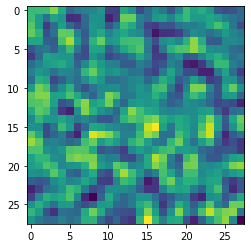

In [158]:
#@markdown Sparse Coding + Sparse Helmholtz
sparse_nat_helmholtz = SparseHelmholtz([400, 32], 'beta', .05)
sparse_nat_helmholtz.train(nat_activations[:, 0].reshape(1, -1), n_iter=5000)

mses = []
psnrs = []
frames = [] 
fig = plt.figure()
for dream in tqdm(sparse_nat_helmholtz.dreams[::1000]):
    dream = nat_model.generate(dream).reshape(28, 28)
    dream = dream - dream.min()
    dream = dream / dream.max()
    mses.append(image_MSE(test_image, dream))
    psnrs.append(image_PSNR(test_image, dream))
    frames.append([plt.imshow(dream, vmin=0, vmax=1, animated=True)])

sparse_mean_MSE = np.array(mses).mean()
sparse_min_MSE = np.array(mses).min()
sparse_mean_PSNR = np.array(psnrs).mean()
sparse_max_PSNR = np.array(psnrs).max()
plt.show()

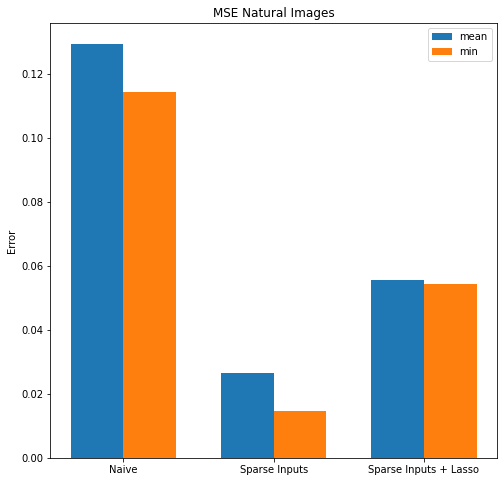

In [159]:
#@markdown Plot MSE for Natural Image
mean_mses = [naive_mean_MSE, helm_mean_MSE, sparse_mean_MSE]
min_mses = [naive_min_MSE, helm_min_MSE, sparse_min_MSE]

x = np.arange(3)
width = 0.35

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.bar(x - width/2, mean_mses, width, label="mean")
ax.bar(x + width/2, min_mses, width, label="min")

ax.set_xticks(x)
ax.set_xticklabels(["Naive", "Sparse Inputs", "Sparse Inputs + Lasso"])

ax.set_title("MSE Natural Images")
ax.set_ylabel("Error")
ax.legend()

plt.savefig("MSE_natural.png")
plt.show()

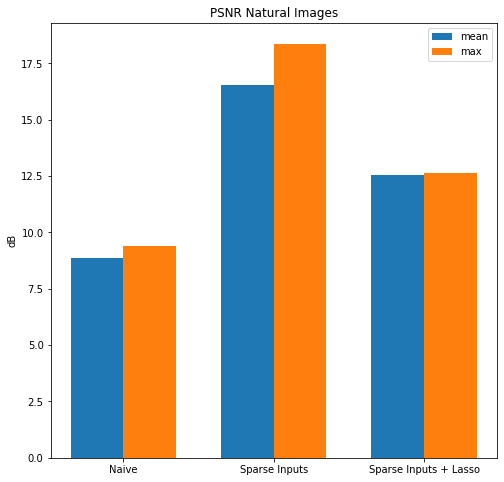

In [160]:
#@markdown Plot PSNR for Natural Image

mean_psnrs = [naive_mean_PSNR, helm_mean_PSNR, sparse_mean_PSNR]
max_psnrs = [naive_max_PSNR, helm_max_PSNR, sparse_max_PSNR]

x = np.arange(3)
width = 0.35

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.bar(x - width/2, mean_psnrs, width, label="mean")
ax.bar(x + width/2, max_psnrs, width, label="max")

ax.set_xticks(x)
ax.set_xticklabels(["Naive", "Sparse Inputs", "Sparse Inputs + Lasso"])

ax.set_title("PSNR Natural Images")
ax.set_ylabel("dB")
ax.legend()

plt.savefig("PNSR_natural.png")
plt.show()